# Lyft: Complete train and prediction pipeline

![](http://www.l5kit.org/_images/av.jpg)
<cite>The image from L5Kit official document: <a href="http://www.l5kit.org/README.html">http://www.l5kit.org/README.html</a></cite>

In this notebook I present an **end-to-end** train and prediction pipeline to predict vehicle motions with a pretrained model included. Unfortunately because of Kaggle memory constraint we can only either run the train part or the prediction part by toggling the parameters in the config part. 

Some of the code here are taken from the kernel:
- [Lyft: Training with multi-mode confidence](https://www.kaggle.com/corochann/lyft-training-with-multi-mode-confidence)
- [Lyft: Prediction with multi-mode confidence](https://www.kaggle.com/corochann/lyft-prediction-with-multi-mode-confidence)

which is part of a wonderful series of introductory notebooks by [corochann](https://www.kaggle.com/corochann)

 - [Lyft: Comprehensive guide to start competition](https://www.kaggle.com/corochann/lyft-comprehensive-guide-to-start-competition)
 - [Lyft: Deep into the l5kit library](https://www.kaggle.com/corochann/lyft-deep-into-the-l5kit-library)
 - [Save your time, submit without kernel inference](https://www.kaggle.com/corochann/save-your-time-submit-without-kernel-inference)
 - [Lyft: pytorch implementation of evaluation metric](https://www.kaggle.com/corochann/lyft-pytorch-implementation-of-evaluation-metric)
 - [Lyft: Training with multi-mode confidence](https://www.kaggle.com/corochann/lyft-training-with-multi-mode-confidence)
 - [Lyft: Prediction with multi-mode confidence](https://www.kaggle.com/corochann/lyft-prediction-with-multi-mode-confidence)
 
**Note:** This notebook aims to create the best single possible, i.e. without any ensemeble, which should only be done near the end of the competition. Since it is still early in the competition, this notebook is still a baseline, any suggestion to improve is appreciated.

# Environment setup

 - Please add [pestipeti/lyft-l5kit-unofficial-fix](https://www.kaggle.com/pestipeti/lyft-l5kit-unofficial-fix) as utility script.
    - Official utility script "[philculliton/kaggle-l5kit](https://www.kaggle.com/mathurinache/kaggle-l5kit)" does not work with pytorch GPU.

Click "File" botton on top-left, and choose "Add utility script". For the pop-up search window, you need to remove "Your Work" filter, and search [pestipeti/lyft-l5kit-unofficial-fix](https://www.kaggle.com/pestipeti/lyft-l5kit-unofficial-fix) on top-right of the search window. Then you can add the kaggle-l5kit utility script. It is much faster to do this rather than !pip install l5kit every time you run the notebook. 

If successful, you can see "usr/lib/lyft-l5kit-unofficial-fix" is added to the "Data" section of this kernel page on right side of the kernel.

- Also please add [pretrained baseline model](https://www.kaggle.com/huanvo/lyft-pretrained-model-hv)

Click on the button "Add data" in the "Data" section and search for lyft-pretrained-model-hv. If you find the model useful, please upvote it as well.  

In [3]:
from typing import Dict

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet50, resnet18, resnet34, resnet101
from torch.utils.data.dataset import Subset
from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

import matplotlib.pyplot as plt

import os
import random
import time

In [4]:
#set random seed
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

## Configs

In [5]:
os.getcwd()

'/home/hoyun/Working/Lyft_Motion_Prediction/notebook'

In [6]:
# --- Lyft configs ---
cfg = {
    'format_version': 4,
    #'data_path': "/kaggle/input/lyft-motion-prediction-autonomous-vehicles",
    'data_path': "../data",
    'model_params': {
        'model_architecture': 'resnet18',
        'history_num_frames': 10,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1,
        'model_name': "model_resnet18_output",
        'lr': 1e-3,
        #'weight_path': "/kaggle/input/lyft-pretrained-model-hv/lyft_pretrained_model.pth",
        'weight_path': "model_resnet18_25k_output_25000.pth",
        #'weight_path': None,
        'train': True,
        'predict': False
    },

    'raster_params': {
        'raster_size': [224, 224],
        'pixel_size': [0.5, 0.5],
        'ego_center': [0.25, 0.5],
        'map_type': 'py_semantic',
        'satellite_map_key': 'aerial_map/aerial_map.png',
        'semantic_map_key': 'semantic_map/semantic_map.pb',
        'dataset_meta_key': 'meta.json',
        'filter_agents_threshold': 0.5
    },

    'train_data_loader': {
        'key': 'scenes/train.zarr',
        'batch_size': 32,
        'shuffle': True,
        'num_workers': 8
    },
    
    'valid_data_loader': {
        'key': 'scenes/validate.zarr',
        'batch_size': 32,
        'shuffle': True,
        'num_workers': 8
    },
    
    'test_data_loader': {
        'key': 'scenes/test.zarr',
        'batch_size': 32,
        'shuffle': False,
        'num_workers': 8
    },

    'train_params': {
        'max_num_steps': 10001,
        'checkpoint_every_n_steps': 5000,
    }
}

Couple of things to note:

 - **model_architecture:** you can put 'resnet18', 'resnet34' or 'resnet50'. For the pretrained model we use resnet18 so we need to use 'resnet18' in the config.
 - **weight_path:** path to the pretrained model. If you don't have a pretrained model and want to train from scratch, put **weight_path** = False. 
 - **model_name:** the name of the model that will be saved as output, this is only when **train**= True.
 - **train:** True if you want to continue to train the model. Unfortunately due to Kaggle memory constraint if **train**=True then you should put **predict** = False.
 - **predict:** True if you want to predict and submit to Kaggle. Unfortunately due to Kaggle memory constraint if you want to predict then you need  to put **train** = False.
 - **lr:** learning rate of the model, feel free to change as you see fit. In the future I also plan to implement learning rate decay. 
 - **raster_size:** specify the size of the image, the default is [224,224]. Increase **raster_size** can improve the score. However the training time will be significantly longer. 
 - **batch_size:** number of inputs for one forward pass, again one of the parameters to tune. 
 - **max_num_steps:** the number of iterations to train, i.e. number of epochs.
 - **checkpoint_every_n_steps:** the model will be saved at every n steps, again change this number as to how you want to keep track of the model.

## Load the train and test data

In [7]:
# set env variable for data
DIR_INPUT = cfg["data_path"]
os.environ["L5KIT_DATA_FOLDER"] = DIR_INPUT
dm = LocalDataManager(None)

In [8]:
# ===== INIT TRAIN DATASET============================================================
train_cfg = cfg["train_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
train_dataset = AgentDataset(cfg, train_zarr, rasterizer)
train_dataloader = DataLoader(train_dataset, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
                             num_workers=train_cfg["num_workers"])
print("==================================TRAIN DATA==================================")
print(train_dataset)

==================================TRAIN DATA==================================
+------------+------------+------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [7]:
valid_cfg = cfg["valid_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
valid_zarr = ChunkedDataset(dm.require(valid_cfg["key"])).open()
valid_dataset = AgentDataset(cfg, valid_zarr, rasterizer)
valid_dataloader = DataLoader(valid_dataset, shuffle=valid_cfg["shuffle"], batch_size=valid_cfg["batch_size"], 
                             num_workers=valid_cfg["num_workers"])
print("==================================valid DATA==================================")
print(valid_dataset)

==================================valid DATA==================================
+------------+------------+------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16220    |  4030296   | 312617887  |      111.97     |        248.48        |        77.57         |        24.85         |        10.00        |
+------------+------------+------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [9]:
#====== INIT TEST DATASET=============================================================
test_cfg = cfg["test_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
test_zarr = ChunkedDataset(dm.require(test_cfg["key"])).open()
test_mask = np.load(f"{DIR_INPUT}/scenes/mask.npz")["arr_0"]
test_dataset = AgentDataset(cfg, test_zarr, rasterizer, agents_mask=test_mask)
test_dataloader = DataLoader(test_dataset,shuffle=test_cfg["shuffle"],batch_size=test_cfg["batch_size"],
                             num_workers=test_cfg["num_workers"])
print("==================================TEST DATA==================================")
print(test_dataset)

warning, you're running with a custom agents_mask
==================================TEST DATA==================================
+------------+------------+------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   11314    |  1131400   |  88594921  |      31.43      |        100.00        |        78.31         |        10.00         |        10.00        |
+------------+------------+------------+-----------------+----------------------+----------------------+----------------------+---------------------+


## Simple visualization

Let us visualize how an input to the model looks like.

In [9]:
def visualize_trajectory(dataset, index, title="target_positions movement with draw_trajectory"):
    data = dataset[index]
    im = data["image"].transpose(1, 2, 0)
    im = dataset.rasterizer.to_rgb(im)
    target_positions_pixels = transform_points(data["target_positions"] + data["centroid"][:2], data["world_to_image"])
    draw_trajectory(im, target_positions_pixels, data["target_yaws"], TARGET_POINTS_COLOR)

    plt.title(title)
    plt.imshow(im[::-1])
    plt.show()

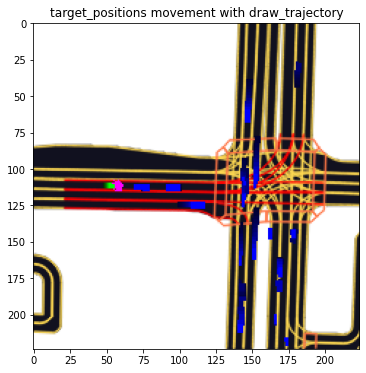

In [10]:
plt.figure(figsize = (8,6))
visualize_trajectory(train_dataset, index=90)

## Loss function

For this competition it is important to use the correct loss function when train the model. Our goal is to predict three possible paths together with the confidence score, so we need to use the loss function that takes that into account, simply using RMSE will not lead to an accurate model. More information about the loss function can be found here [negative log likelihood](https://github.com/lyft/l5kit/blob/master/competition.md).

In [11]:
# --- Function utils ---
# Original code from https://github.com/lyft/l5kit/blob/20ab033c01610d711c3d36e1963ecec86e8b85b6/l5kit/l5kit/evaluation/metrics.py
import numpy as np

import torch
from torch import Tensor


def pytorch_neg_multi_log_likelihood_batch(
    gt: Tensor, pred: Tensor, confidences: Tensor, avails: Tensor
) -> Tensor:
    """
    Compute a negative log-likelihood for the multi-modal scenario.
    log-sum-exp trick is used here to avoid underflow and overflow, For more information about it see:
    https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations
    https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
    https://leimao.github.io/blog/LogSumExp/
    Args:
        gt (Tensor): array of shape (bs)x(time)x(2D coords)
        pred (Tensor): array of shape (bs)x(modes)x(time)x(2D coords)
        confidences (Tensor): array of shape (bs)x(modes) with a confidence for each mode in each sample
        avails (Tensor): array of shape (bs)x(time) with the availability for each gt timestep
    Returns:
        Tensor: negative log-likelihood for this example, a single float number
    """
    assert len(pred.shape) == 4, f"expected 3D (MxTxC) array for pred, got {pred.shape}"
    batch_size, num_modes, future_len, num_coords = pred.shape

    assert gt.shape == (batch_size, future_len, num_coords), f"expected 2D (Time x Coords) array for gt, got {gt.shape}"
    assert confidences.shape == (batch_size, num_modes), f"expected 1D (Modes) array for gt, got {confidences.shape}"
    assert torch.allclose(torch.sum(confidences, dim=1), confidences.new_ones((batch_size,))), "confidences should sum to 1"
    assert avails.shape == (batch_size, future_len), f"expected 1D (Time) array for gt, got {avails.shape}"
    # assert all data are valid
    assert torch.isfinite(pred).all(), "invalid value found in pred"
    assert torch.isfinite(gt).all(), "invalid value found in gt"
    assert torch.isfinite(confidences).all(), "invalid value found in confidences"
    assert torch.isfinite(avails).all(), "invalid value found in avails"

    # convert to (batch_size, num_modes, future_len, num_coords)
    gt = torch.unsqueeze(gt, 1)  # add modes
    avails = avails[:, None, :, None]  # add modes and cords

    # error (batch_size, num_modes, future_len)
    error = torch.sum(((gt - pred) * avails) ** 2, dim=-1)  # reduce coords and use availability

    with np.errstate(divide="ignore"):  # when confidence is 0 log goes to -inf, but we're fine with it
        # error (batch_size, num_modes)
        error = torch.log(confidences) - 0.5 * torch.sum(error, dim=-1)  # reduce time

    # use max aggregator on modes for numerical stability
    # error (batch_size, num_modes)
    max_value, _ = error.max(dim=1, keepdim=True)  # error are negative at this point, so max() gives the minimum one
    error = -torch.log(torch.sum(torch.exp(error - max_value), dim=-1, keepdim=True)) - max_value  # reduce modes
    # print("error", error)
    return torch.mean(error)


def pytorch_neg_multi_log_likelihood_single(
    gt: Tensor, pred: Tensor, avails: Tensor
) -> Tensor:
    """

    Args:
        gt (Tensor): array of shape (bs)x(time)x(2D coords)
        pred (Tensor): array of shape (bs)x(time)x(2D coords)
        avails (Tensor): array of shape (bs)x(time) with the availability for each gt timestep
    Returns:
        Tensor: negative log-likelihood for this example, a single float number
    """
    # pred (bs)x(time)x(2D coords) --> (bs)x(mode=1)x(time)x(2D coords)
    # create confidence (bs)x(mode=1)
    batch_size, future_len, num_coords = pred.shape
    confidences = pred.new_ones((batch_size, 1))
    return pytorch_neg_multi_log_likelihood_batch(gt, pred.unsqueeze(1), confidences, avails)

## Model

Next we define the baseline model. Note that this model will return three possible trajectories together with confidence score for each trajectory.

In [12]:
class LyftMultiModel(nn.Module):

    def __init__(self, cfg: Dict, num_modes=3):
        super().__init__()

        architecture = cfg["model_params"]["model_architecture"]
        backbone = eval(architecture)(pretrained=True, progress=True)
        self.backbone = backbone

        num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
        num_in_channels = 3 + num_history_channels

        self.backbone.conv1 = nn.Conv2d(
            num_in_channels,
            self.backbone.conv1.out_channels,
            kernel_size=self.backbone.conv1.kernel_size,
            stride=self.backbone.conv1.stride,
            padding=self.backbone.conv1.padding,
            bias=False,
        )

        # This is 512 for resnet18 and resnet34;
        # And it is 2048 for the other resnets
        
        if architecture == "resnet50":
            backbone_out_features = 2048
        else:
            backbone_out_features = 512

        # X, Y coords for the future positions (output shape: batch_sizex50x2)
        self.future_len = cfg["model_params"]["future_num_frames"]
        num_targets = 2 * self.future_len

        # You can add more layers here.
        self.head = nn.Sequential(
            # nn.Dropout(0.2),
            nn.Linear(in_features=backbone_out_features, out_features=4096),
        )

        self.num_preds = num_targets * num_modes
        self.num_modes = num_modes

        self.logit = nn.Linear(4096, out_features=self.num_preds + num_modes)

    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)

        x = self.head(x)
        x = self.logit(x)

        # pred (batch_size)x(modes)x(time)x(2D coords)
        # confidences (batch_size)x(modes)
        bs, _ = x.shape
        pred, confidences = torch.split(x, self.num_preds, dim=1)
        pred = pred.view(bs, self.num_modes, self.future_len, 2)
        assert confidences.shape == (bs, self.num_modes)
        confidences = torch.softmax(confidences, dim=1)
        return pred, confidences

In [13]:
def forward(data, model, device, criterion = pytorch_neg_multi_log_likelihood_batch):
    inputs = data["image"].to(device)
    target_availabilities = data["target_availabilities"].to(device)
    targets = data["target_positions"].to(device)
    # Forward pass
    preds, confidences = model(inputs)
    loss = criterion(targets, preds, confidences, target_availabilities)
    return loss, preds

Now let us initialize the model and load the pretrained weights. Note that since the pretrained model was trained on GPU, you also need to enable GPU when running this notebook.

In [14]:
# ==== INIT MODEL=================
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LyftMultiModel(cfg)

#load weight if there is a pretrained model
weight_path = cfg["model_params"]["weight_path"]
if weight_path:
    model.load_state_dict(torch.load(weight_path))

model.to(device)
optimizer = optim.Adam(model.parameters(), lr=cfg["model_params"]["lr"])
print(f'device {device}')

device cuda:0


In [15]:
print(model)

LyftMultiModel(
  (backbone): ResNet(
    (conv1): Conv2d(25, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

## Training loop

Next let us implement the training loop, when the **train** parameter is set to True. 

In [16]:
# ==== TRAINING LOOP =========================================================
if cfg["model_params"]["train"]:
    
    tr_it = iter(train_dataloader)
    progress_bar = tqdm(range(cfg["train_params"]["max_num_steps"]))
    num_iter = cfg["train_params"]["max_num_steps"]
    losses_train = []
    iterations = []
    metrics = []
    times = []
    model_name = cfg["model_params"]["model_name"]
    start = time.time()

    for i in progress_bar:
        try:
            data = next(tr_it)
        except StopIteration:
            tr_it = iter(train_dataloader)
            data = next(tr_it)
        model.train()
        torch.set_grad_enabled(True)

        loss, _ = forward(data, model, device)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses_train.append(loss.item())
        """
        with torch.no_grad():  
            for x_val, y_val in val_loader:  
                x_val = x_val.to(device)  
                y_val = y_val.to(device)  

                model.eval()  

                yhat = model(x_val)  
                val_loss = loss_fn(yhat, y_val)  
                val_losses.append(val_loss.item())
                evaluate(model, valid_dataloader, device=device)
        """        
        progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")
        if i % (cfg['train_params']['checkpoint_every_n_steps']+1) == 0:
            torch.save(model.state_dict(), f'{model_name}_{i}.pth')
            iterations.append(i)
            metrics.append(np.mean(losses_train))
            times.append((time.time()-start)/60)

    results = pd.DataFrame({'iterations': iterations, 'metrics (avg)': metrics, 'elapsed_time (mins)': times})
    results.to_csv(f"train_metrics_{model_name}_{num_iter}.csv", index = False)
    print(f"Total training time is {(time.time()-start)/60} mins")
    print(results.head())

## Validation

In [17]:
# # ==== EVAL LOOP ================================================================
# if cfg["model_params"]["predict"]:
    
#     model.eval()
#     torch.set_grad_enabled(False)

#     # store information for evaluation
#     future_coords_offsets_pd = []
#     timestamps = []
#     confidences_list = []
#     agent_ids = []

#     progress_bar = tqdm(valid_dataloader)
#     for data in progress_bar:
#         inputs = data['image'].to(device)
#         preds, confidences  = model(inputs)
#         loss, _ = forward(data, model, device)
#         future_coords_offsets_pd.append(preds.cpu().numpy().copy())
#         confidences_list.append(confidences.cpu().numpy().copy())
#         timestamps.append(data["timestamp"].numpy().copy())
#         agent_ids.append(data["track_id"].numpy().copy())
        
#     #create submission to submit to Kaggle
#     pred_path = 'submission.csv'
#     write_pred_csv(pred_path,
#                timestamps=np.concatenate(timestamps),
#                track_ids=np.concatenate(agent_ids),
#                coords=np.concatenate(future_coords_offsets_pd),
#                confs = np.concatenate(confidences_list)
#               )

## Prediction

Finally we implement the inference to submit to Kaggle when **predict** param is set to True.

In [18]:
# ==== EVAL LOOP ================================================================
if cfg["model_params"]["predict"]:
    
    model.eval()
    torch.set_grad_enabled(False)

    # store information for evaluation
    future_coords_offsets_pd = []
    timestamps = []
    confidences_list = []
    agent_ids = []

    progress_bar = tqdm(test_dataloader)
    for data in progress_bar:
        inputs = data['image'].to(device)
        preds, confidences  = model(inputs)
        future_coords_offsets_pd.append(preds.cpu().numpy().copy())
        confidences_list.append(confidences.cpu().numpy().copy())
        timestamps.append(data["timestamp"].numpy().copy())
        agent_ids.append(data["track_id"].numpy().copy())
        
    #create submission to submit to Kaggle
    pred_path = 'submission.csv'
    write_pred_csv(pred_path,
               timestamps=np.concatenate(timestamps),
               track_ids=np.concatenate(agent_ids),
               coords=np.concatenate(future_coords_offsets_pd),
               confs = np.concatenate(confidences_list)
              )

100%|██████████| 2223/2223 [10:26<00:00,  3.55it/s]


<h3 style="color:red">That is it. Feel free to modify this kernel as you wish. Let me know your suggestions in the comments below.</h3>
<h3 style="color:red"> Please upvote if this kernel helps you. Thanks!</h3>